# Preparação e tratamento dos dados - Parte 2

## Objetivo

Este código tem como objetivo tratar a base "ans.csv" desenvolvida na parte 1

As etapas abordadas no tratamento de dados desenvolvido neste código são as seguintes:

1. Filtragem por tipo de contratação, porte e modalidade de operadora
1. Agrupamento das informações de receita, despesa e total de beneficiarios
1. Identificação e tratamento de dados outliers de receita e despesa
1. Criação da base para ser utilizada na etapa de forecast

## Este código aborda as informações do seguinte segmento:

### Individual - Modalidade Seguradora

In [47]:
#Bibliotecas
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.6f}'.format

In [48]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

### Seleção do Período para o tratamento dos dados

In [49]:
#Seleção do Periodo de análise

inicio = '2017-09-01'

fim = '2022-03-01'

Periodo = [inicio, fim]

### Parametros para filtragem dos dados

In [50]:
#Parametros para filtragem dos dados

contratacao_list = ['Adesao', 'Empresarial', 'Individual']

modalidade_list = ['Medicina de Grupo', 'Cooperativa Médica', 'Autogestão', 'Filantropia', 'Seguradora']

tipo_contratacao = 'Individual'

tipo_modalidade = 'Seguradora'

## Leitura dos dados

Carregamento e leitura da base desenvolvida na parte 1 do código

In [51]:
path = f'D:/TCC/tcc-main/codigos/preparacao_dados/analise_agrupadas' + '\\' + 'ans.csv'

ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')  #Leitura da base

#modificando os tipos de dados

ans['ano'] = ans['ano'].astype('str')

ans['cd_ops'] = ans['cd_ops'].astype('str')

ans['lg_cancelada'] = ans['lg_cancelada'].astype('str')

ans['lg_nova_ops'] = ans['lg_nova_ops'].astype('str')

ans['ano'] = pd.PeriodIndex(ans['ano'], freq="Y")

ans['trimestre'] = pd.PeriodIndex(ans['trimestre'], freq="Q")

#Filtrando os dados até 2021
ans = ans[(ans.ano < '2022')]

ans = ans.replace(' NaN', np.NaN)

ans = ans.dropna()

#Filtra somente as operadas com flag ativas
ans_filt = ans[(ans['lg_cancelada']!='1.0') & (ans['benef']!=np.nan)].reset_index(drop=True)

ans_filt.head()

,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,receita,despesa,benef,lg_cancelada,lg_nova_ops
0,2017,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/09/2017,2017Q3,2095967.190000,0.000000,747.000000,0.0,0.0
1,2017,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/12/2017,2017Q4,785491.930000,0.000000,719.000000,0.0,0.0
2,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/03/2018,2018Q1,791860.200000,0.000000,722.000000,0.0,0.0
3,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2018,2018Q2,769499.340000,0.000000,731.000000,0.0,0.0
4,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/09/2018,2018Q3,846654.020000,0.000000,774.000000,0.0,0.0


In [52]:
#Filtra o segmento abordado neste código
ans_filt_cont_mod = ans_filt[ (ans_filt['contratacao'] == tipo_contratacao) & 
                              (ans_filt['modalidade'] == tipo_modalidade)].reset_index(drop=True)

ans_filt_cont_mod = ans_filt_cont_mod[['ano', 'cd_ops', 'razao_social', 'modalidade', 'port_ops', 'vigencia', 'contratacao', 'financiamento', 'trimestre', 'receita', 'despesa', 'benef']]

ans_filt_cont_mod.head()

,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,trimestre,receita,despesa,benef
0,2017,477,SUL AMÉRICA SEGURADORA DE SAÚDE S.A.,Seguradora,Grande,P,Individual,Pre-estabelecido,2017Q3,38005488.850000,42946986.860000,2674.000000
1,2017,477,SUL AMÉRICA SEGURADORA DE SAÚDE S.A.,Seguradora,Grande,P,Individual,Pre-estabelecido,2017Q4,13587719.890000,13328806.480000,2636.000000
2,2018,477,SUL AMÉRICA SEGURADORA DE SAÚDE S.A.,Seguradora,Grande,P,Individual,Pre-estabelecido,2018Q1,13661202.120000,11198782.630000,2595.000000
3,2018,477,SUL AMÉRICA SEGURADORA DE SAÚDE S.A.,Seguradora,Grande,P,Individual,Pre-estabelecido,2018Q2,13786063.370000,13417106.750000,2549.000000
4,2018,477,SUL AMÉRICA SEGURADORA DE SAÚDE S.A.,Seguradora,Grande,P,Individual,Pre-estabelecido,2018Q3,14382991.760000,16168647.310000,2492.000000


In [53]:
ans_filt_cont_mod[['ano','cd_ops','trimestre','receita','despesa','benef','modalidade','port_ops','contratacao']].to_csv('ind_seg.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_filt_cont_mod.groupby(['ano','cd_ops','razao_social','trimestre']).agg({'receita':lambda x: sum_million(x),'despesa':lambda x: sum_million(x)}).head()

receita    despesa
ano  cd_ops razao_social                          trimestre                      
2017 477    SUL AMÉRICA SEGURADORA DE SAÚDE S.A.  2017Q3     38.010000  42.950000
                                                  2017Q4     13.590000  13.330000
     5711   BRADESCO SAÚDE S.A.                   2017Q3    346.720000 343.740000
                                                  2017Q4    124.860000 112.000000
     6246   SUL AMERICA COMPANHIA DE SEGURO SAÚDE 2017Q3    384.920000 370.990000

In [54]:
ans_filt_cont_mod_agrup = ans_filt_cont_mod.groupby(['ano','trimestre'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                             'despesa':lambda x: sum_million(x),
                                                                                             'benef': 'sum',
                                                                                             'cd_ops':lambda x: x.nunique()})

ans_filt_cont_mod_agrup['pct_despesa'] = ans_filt_cont_mod_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_filt_cont_mod_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[(ans_filt_cont_mod_agrup.trimestre > '2017Q4') & (ans_filt_cont_mod_agrup.trimestre < '2022Q1')]

ans_filt_cont_mod_agrup[['n_ops','benef']] = ans_filt_cont_mod_agrup[['n_ops','benef']].astype('int')

ans_filt_cont_mod_agrup.to_csv('ind_seg_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_filt_cont_mod_agrup.set_index('trimestre', inplace=True)

ans_filt_cont_mod_agrup

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,291.320000,250.410000,55593,5,85.960000
2018Q2,300.340000,277.630000,54200,5,92.440000
2018Q3,294.750000,290.060000,52992,5,98.410000
2018Q4,313.810000,282.560000,51520,5,90.040000
2019Q1,311.780000,279.790000,50264,5,89.740000
2019Q2,312.280000,285.860000,49032,5,91.540000
2019Q3,319.070000,322.840000,47820,5,101.180000
2019Q4,329.070000,303.230000,46607,5,92.150000
2020Q1,325.340000,298.370000,45612,5,91.710000


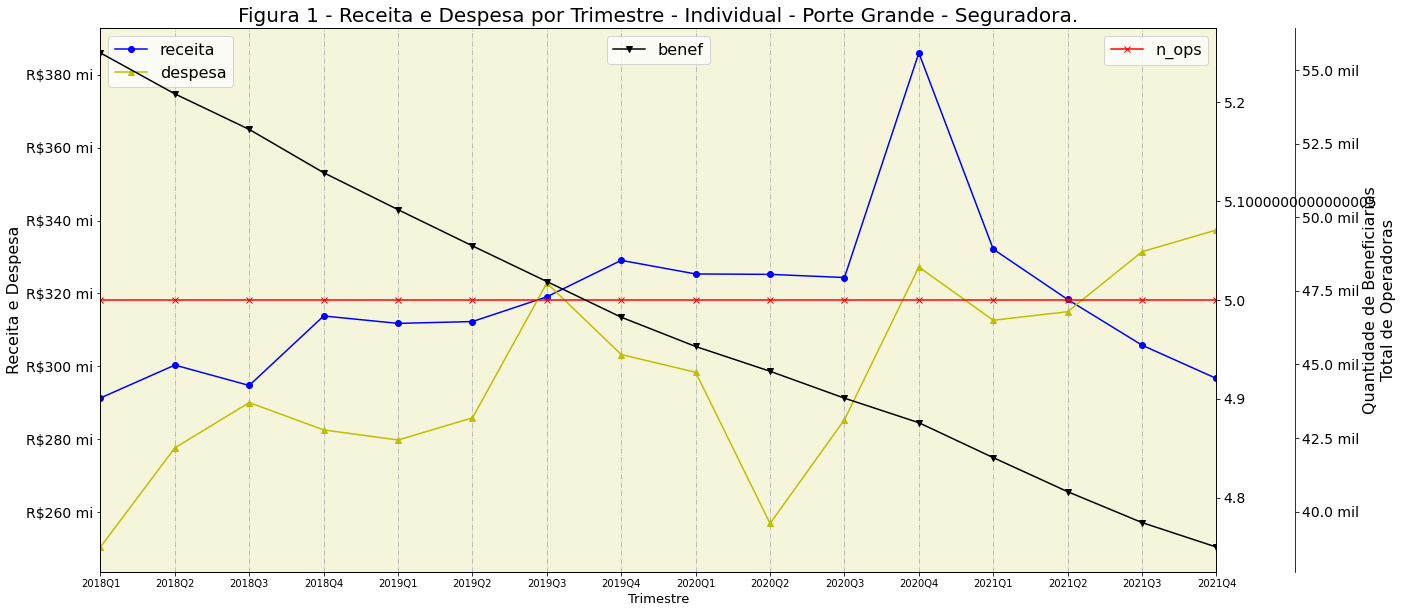

In [55]:
df_plot = ans_filt_cont_mod_agrup.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Individual - Porte Grande - Seguradora.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks, fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mil'.format(x/1e3) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.savefig('ind_seg_01.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [56]:
#Cria o ranking das operadoras com maior receita e despesa
ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':lambda x: sum_million(x),
                                                                                                           'despesa':lambda x: sum_million(x),
                                                                                                           'benef': 'sum'}).reset_index(drop=True)

ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod_agrup_ops.sort_values(['benef'],ascending = False).groupby('trimestre').head(100).reset_index(drop=True)

#ans_filt_ind_seg_agrup_ops.sort_values(by=['ano','benef'], ascending=[True,False], inplace=True)

ans_filt_cont_mod_agrup_ops.head()

,ano,cd_ops,trimestre,receita,despesa,benef
0,2017,6246,2017Q3,384.920000,370.990000,25727.000000
1,2017,5711,2017Q3,346.720000,343.740000,25492.000000
2,2017,6246,2017Q4,133.940000,133.410000,25246.000000
3,2017,5711,2017Q4,124.860000,112.000000,25022.000000
4,2018,5711,2018Q1,128.130000,103.420000,24715.000000


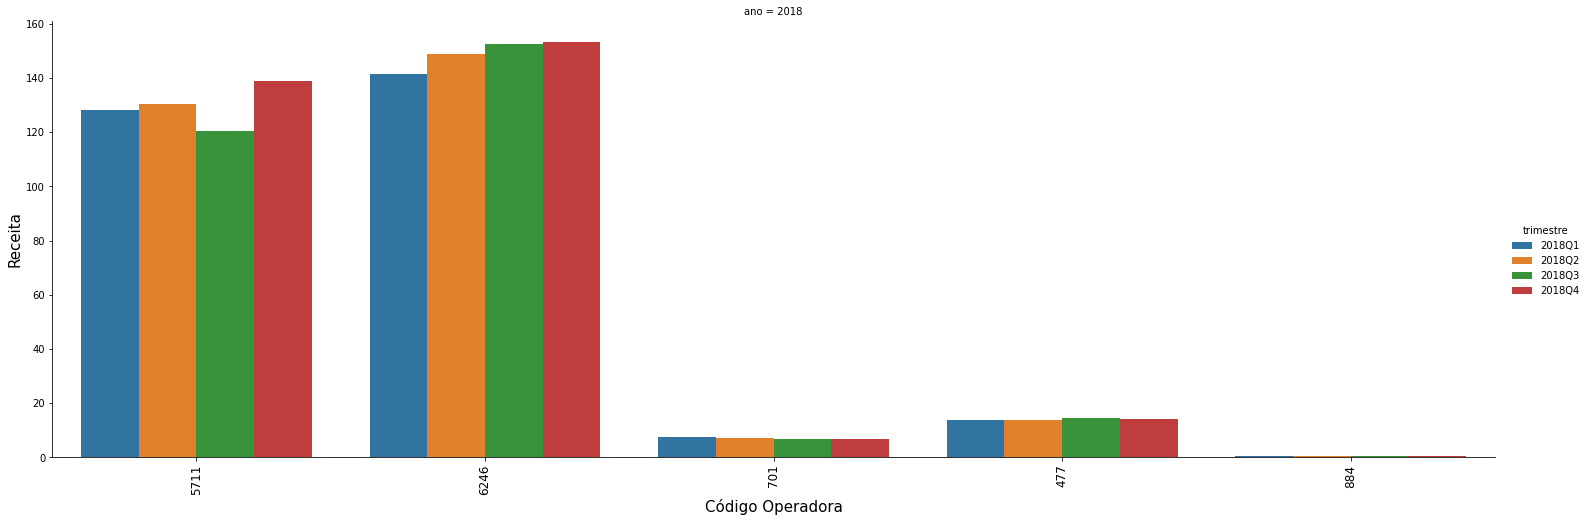

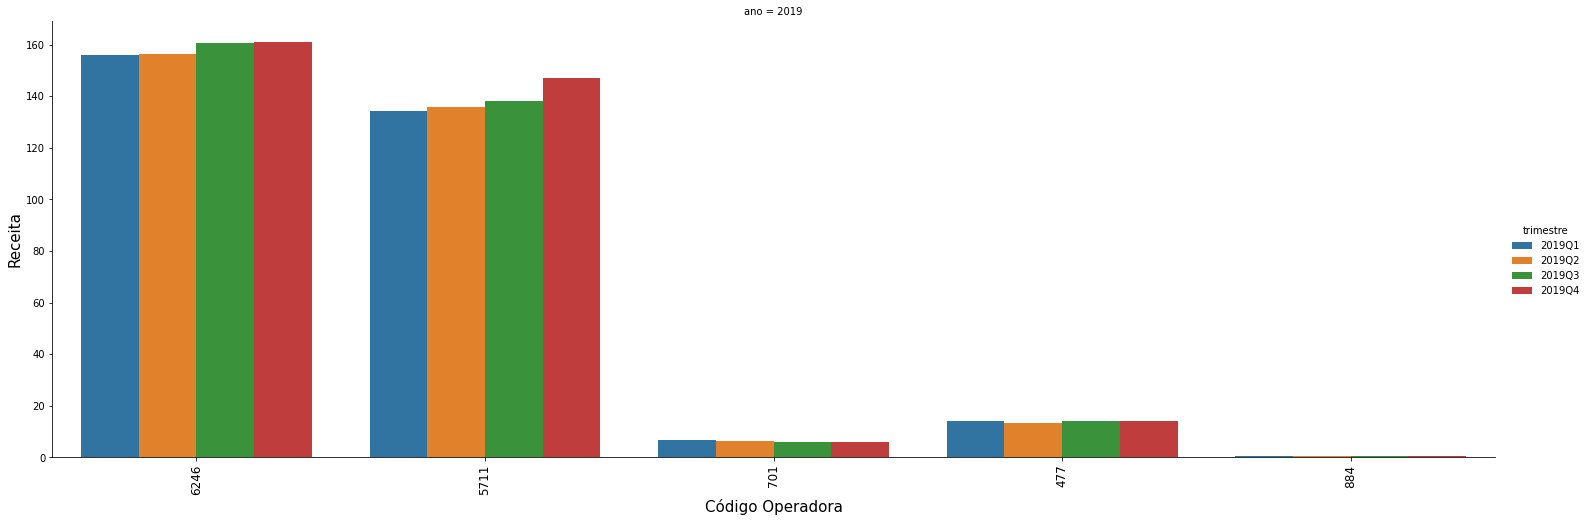

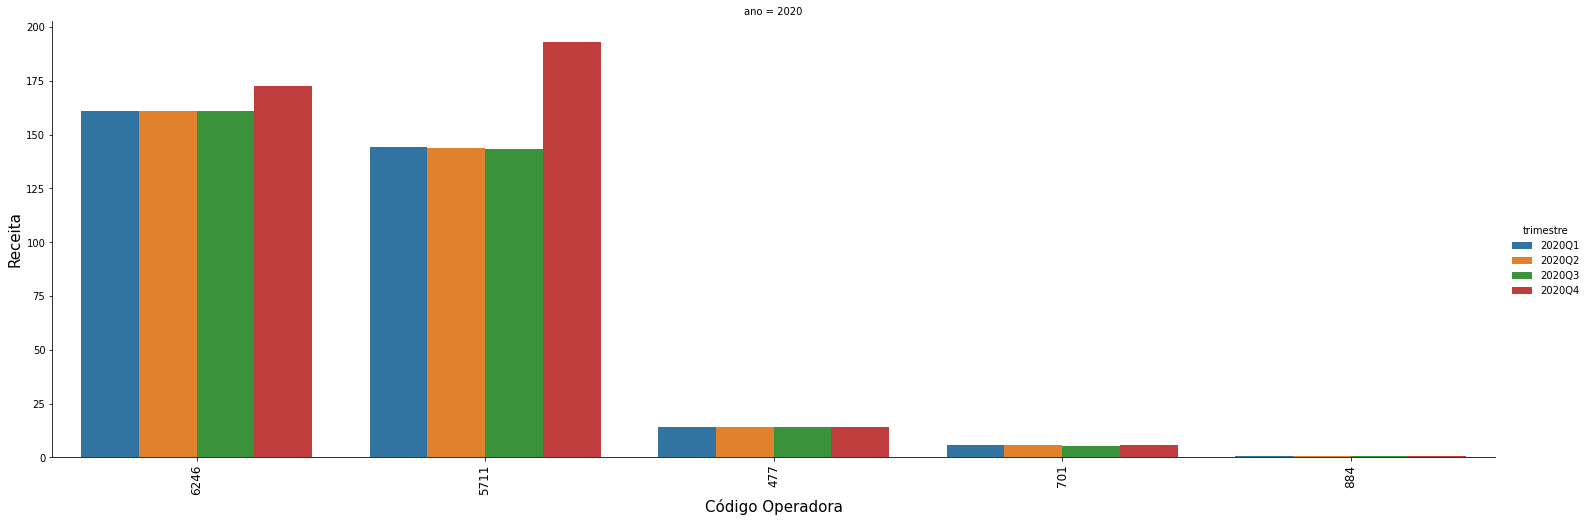

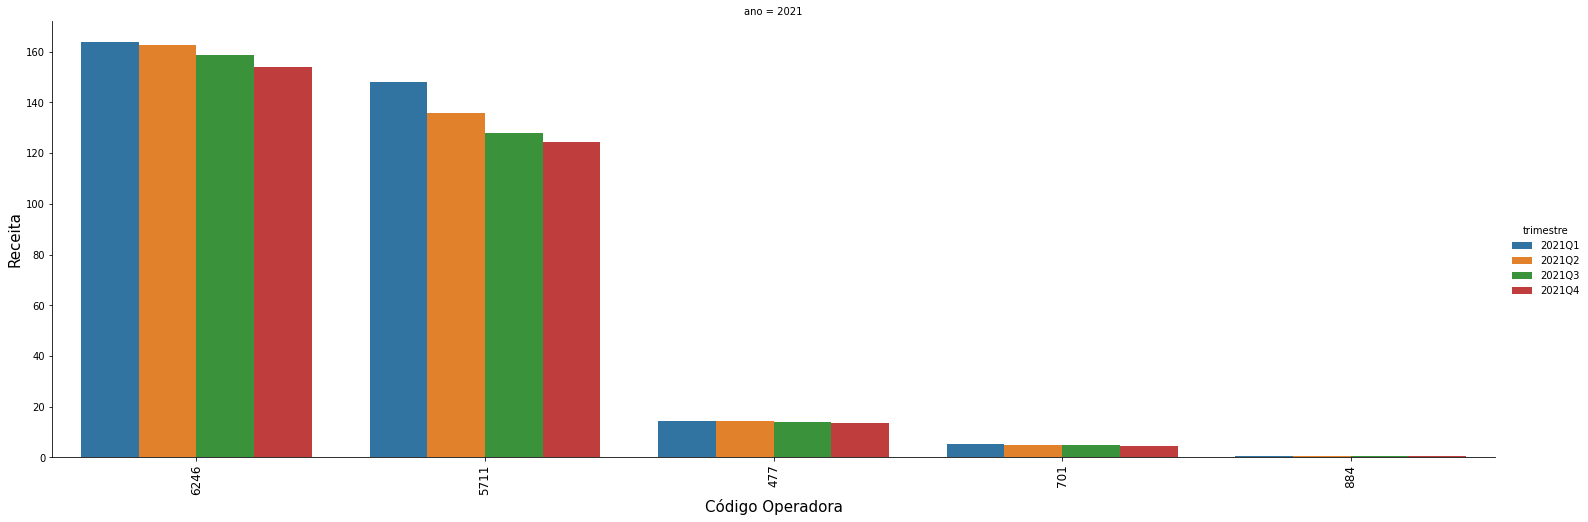

In [57]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

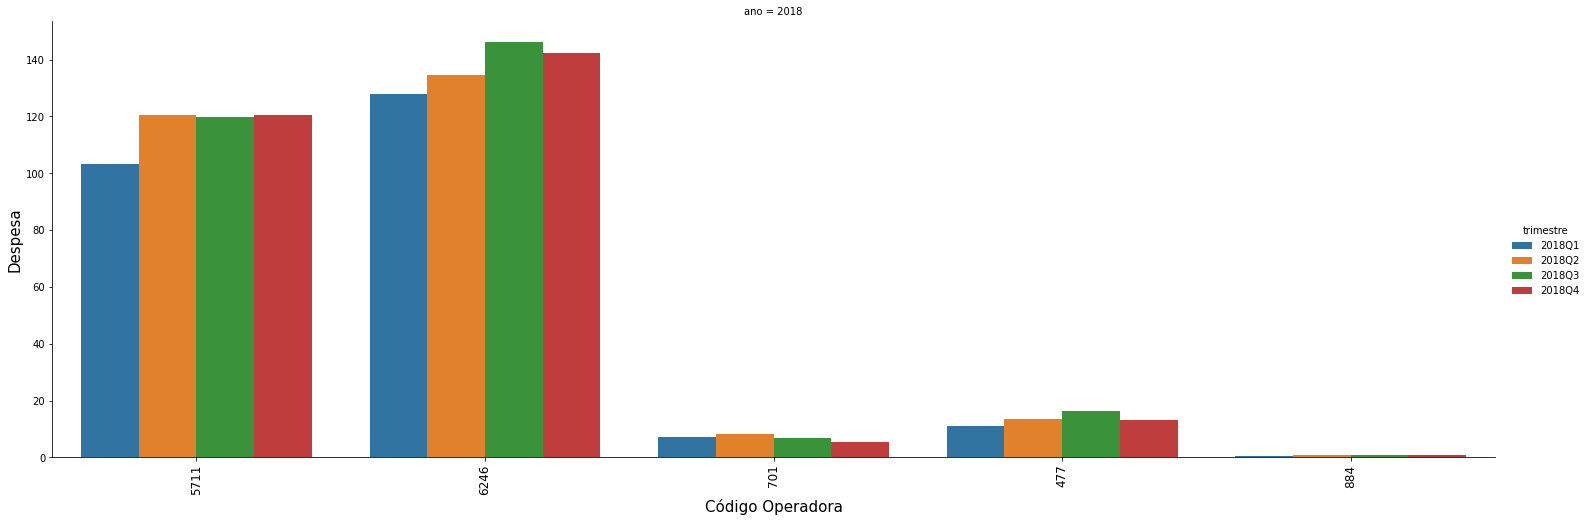

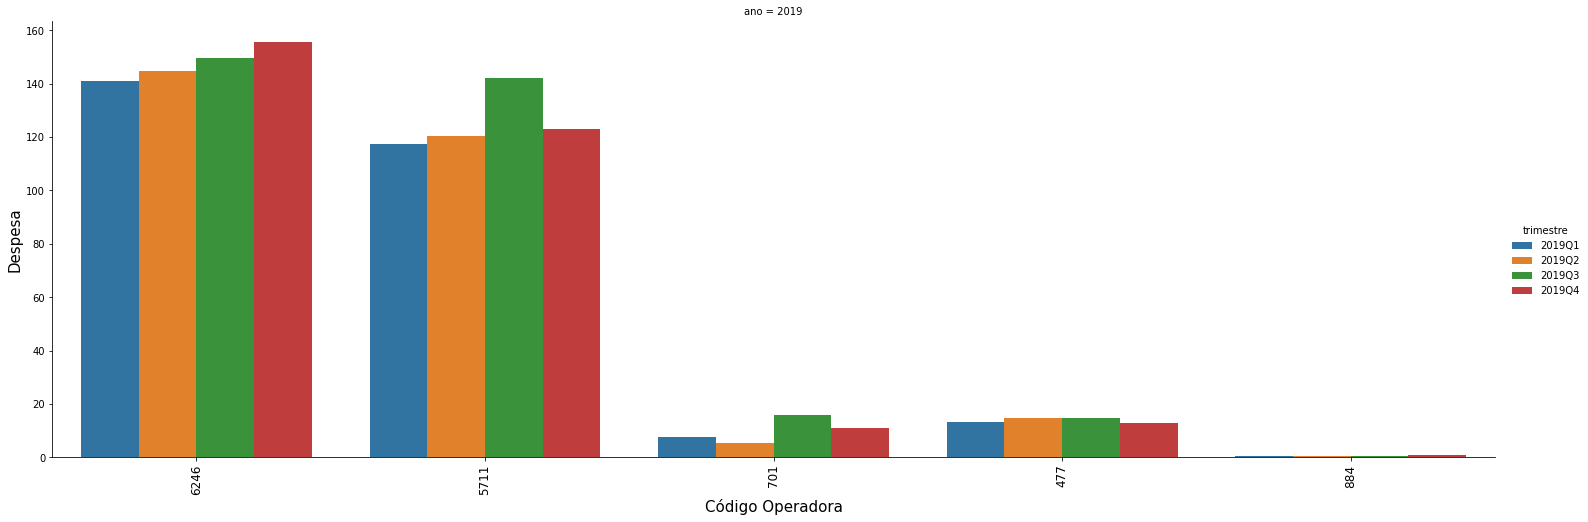

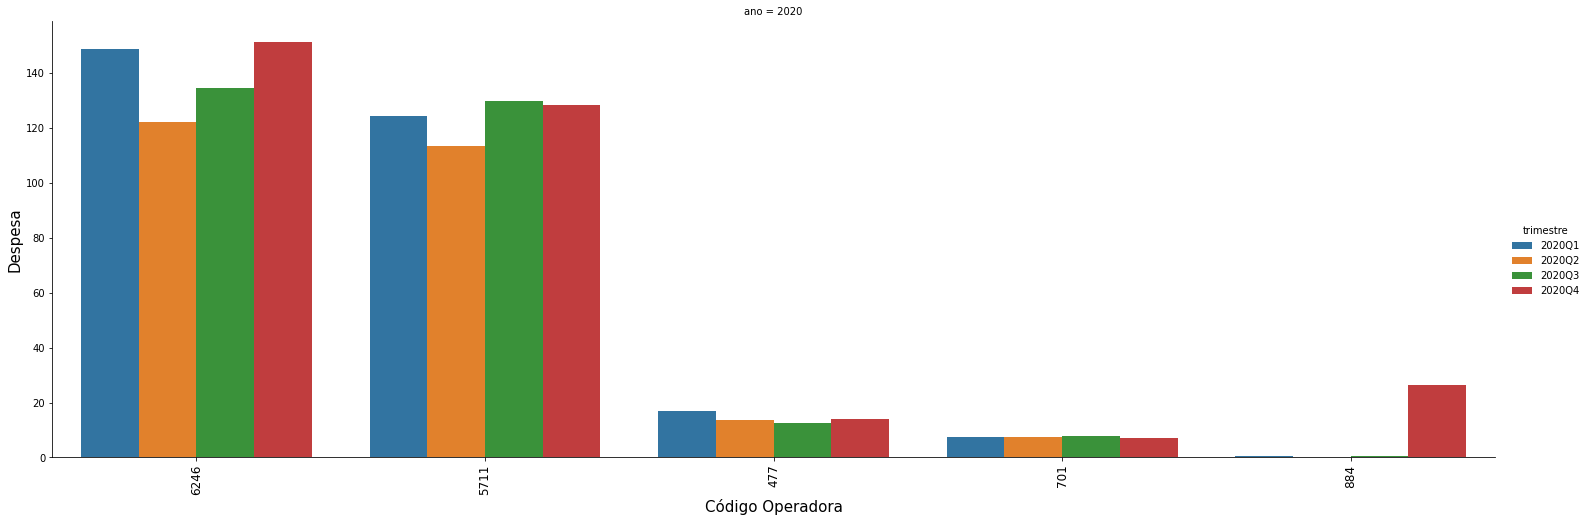

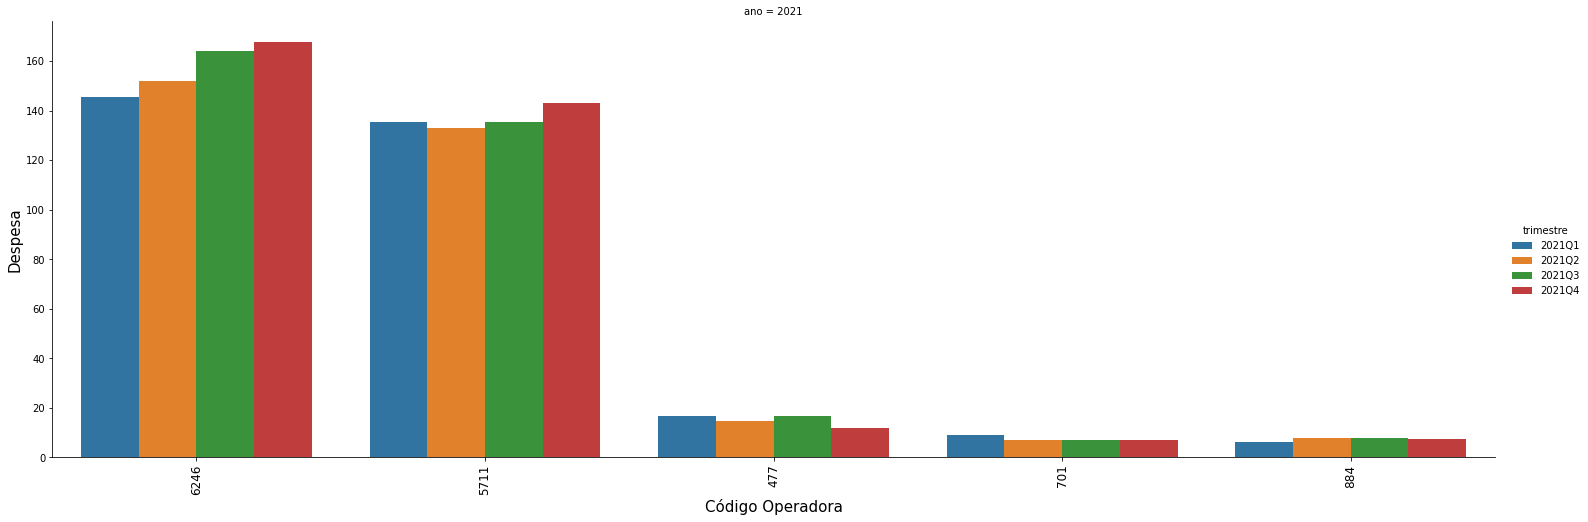

In [58]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

### 2ª Etapa

Corrigindo alguns pontos outliers que nao acompanham o crescimento médio da curva de receita e despesa

In [59]:
#Base com a quantidade de operadoras corrigida

ans_alterada14 = ans_filt_cont_mod[['ano','cd_ops','trimestre','receita','despesa']]

display(ans_alterada14.info())

display(ans_alterada14.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype        
---  ------     --------------  -----        
 0   ano        90 non-null     period[A-DEC]
 1   cd_ops     90 non-null     object       
 2   trimestre  90 non-null     period[Q-DEC]
 3   receita    90 non-null     float64      
 4   despesa    90 non-null     float64      
dtypes: float64(2), object(1), period[A-DEC](1), period[Q-DEC](1)
memory usage: 3.6+ KB


None

,ano,cd_ops,trimestre,receita,despesa
0,2017,477,2017Q3,38005488.850000,42946986.860000
1,2017,477,2017Q4,13587719.890000,13328806.480000
2,2018,477,2018Q1,13661202.120000,11198782.630000
3,2018,477,2018Q2,13786063.370000,13417106.750000
4,2018,477,2018Q3,14382991.760000,16168647.310000


In [60]:
ans_alterada16 = ans_alterada14.groupby(['ano','cd_ops'], as_index=False).agg(  receita_total = ('receita','sum'),
                                                                                despesa_total = ('despesa','sum'))

ans_alterada17 = pd.merge(ans_alterada14,ans_alterada16, how='left', on=['ano','cd_ops'])

#Escolha do ano que possui pontos fora a curva média de crescimento da receita e despesa
ans_alterada17 = ans_alterada17[(ans_alterada17['ano']=='2018') | (ans_alterada17['ano']=='2019') | (ans_alterada17['ano']=='2020')]

ans_alterada17['pct_receita'] = ans_alterada17['receita'] / ans_alterada17['receita_total']
ans_alterada17['pct_despesa'] = ans_alterada17['despesa'] / ans_alterada17['despesa_total']

ans_alterada17.head()

,ano,cd_ops,trimestre,receita,despesa,receita_total,despesa_total,pct_receita,pct_despesa
2,2018,477,2018Q1,13661202.120000,11198782.630000,56132004.660000,54031094.020000,0.243376,0.207266
3,2018,477,2018Q2,13786063.370000,13417106.750000,56132004.660000,54031094.020000,0.245601,0.248322
4,2018,477,2018Q3,14382991.760000,16168647.310000,56132004.660000,54031094.020000,0.256235,0.299247
5,2018,477,2018Q4,14301747.410000,13246557.330000,56132004.660000,54031094.020000,0.254788,0.245165
6,2019,477,2019Q1,14259958.450000,13290855.760000,55816629.560000,55743415.290000,0.255479,0.238429


In [61]:
#calculado o valor limite dos outliers
stats_ans_alterada3 = ans_alterada17.groupby(['ano','trimestre'])[['pct_receita','pct_despesa']].describe(percentiles = [.51])

stats_ans_alterada3

pct_receita                                                       pct_despesa                                                      
                     count     mean      std      min      50%      51%      max       count     mean      std      min      50%      51%      max
ano  trimestre                                                                                                                                    
2018 2018Q1       5.000000 0.248290 0.012847 0.237217 0.243376 0.243540 0.270324    5.000000 0.217975 0.033201 0.168867 0.222888 0.223259 0.258684
     2018Q2       5.000000 0.248884 0.002317 0.245601 0.249518 0.249532 0.251708    5.000000 0.262915 0.021160 0.244180 0.259455 0.259673 0.297715
     2018Q3       5.000000 0.248294 0.012154 0.232892 0.255942 0.255954 0.258972    5.000000 0.274463 0.025468 0.246368 0.265291 0.266649 0.303386
     2018Q4       5.000000 0.254532 0.009070 0.244523 0.254788 0.254889 0.267933    5.000000 0.244647 0.027350 0.197233 0.258362 0.258413 0.262844
2019 2019Q1       5.000000 0.250456 0.007994 0.241912 0.246912 0.247255 0.261731    5.000000 0.226105 0.019609 0.191820 0.233671 0.233856 0.238429
     2019Q2       5.000000 0.246915 0.004619 0.240885 0.246644 0.246797 0.252309    5.000000 0.223836 0.052936 0.131694 0.239289 0.239520 0.267246
     2019Q3       5.000000 0.248977 0.003951 0.242486 0.250115 0.250132 0.253032    5.000000 0.281033 0.073809 0.202641 0.265062 0.265753 0.401924
     2019Q4       5.000000 0.253652 0.007718 0.243474 0.253522 0.253544 0.265138    5.000000 0.269026 0.039835 0.229263 0.263443 0.263888 0.333157
2020 2020Q1       5.000000 0.247462 0.010912 0.230655 0.250093 0.250113 0.260600    5.000000 0.216858 0.112230 0.019530 0.250724 0.251392 0.299450
     2020Q2       5.000000 0.244611 0.008062 0.230426 0.248222 0.248243 0.249815    5.000000 0.189284 0.101355 0.009218 0.228651 0.229029 0.251263
     2020Q3       5.000000 0.243326 0.008823 0.229638 0.245556 0.245720 0.251622    5.000000 0.200396 0.103846 0.017290 0.241481 0.242290 0.262027
     2020Q4       5.000000 0.264601 0.025614 0.249550 0.250498 0.251008 0.309280    5.000000 0.393461 0.313593 0.239890 0.258598 0.259129 0.953962

In [62]:
stats_ans_alterada4 = stats_ans_alterada3.reset_index(level=[0,1])

stats_ans_alterada4.columns = ['_'.join(col) for col in stats_ans_alterada4.columns.values]

stats_ans_alterada4 = stats_ans_alterada4[['ano_','trimestre_','pct_receita_mean','pct_despesa_mean','pct_receita_50%','pct_despesa_50%','pct_receita_51%', 'pct_despesa_51%']]

stats_ans_alterada4.rename(columns = {'ano_':'ano',
                                      'trimestre_':'trimestre',
                                      'pct_receita_50%':'pct_receita_50',
                                      'pct_despesa_50%':'pct_despesa_50',
                                      'pct_receita_51%':'pct_receita_ref',
                                      'pct_despesa_51%':'pct_despesa_ref'}, inplace = True)

stats_ans_alterada4

,ano,trimestre,pct_receita_mean,pct_despesa_mean,pct_receita_50,pct_despesa_50,pct_receita_ref,pct_despesa_ref
0,2018,2018Q1,0.248290,0.217975,0.243376,0.222888,0.243540,0.223259
1,2018,2018Q2,0.248884,0.262915,0.249518,0.259455,0.249532,0.259673
2,2018,2018Q3,0.248294,0.274463,0.255942,0.265291,0.255954,0.266649
3,2018,2018Q4,0.254532,0.244647,0.254788,0.258362,0.254889,0.258413
4,2019,2019Q1,0.250456,0.226105,0.246912,0.233671,0.247255,0.233856
5,2019,2019Q2,0.246915,0.223836,0.246644,0.239289,0.246797,0.239520
6,2019,2019Q3,0.248977,0.281033,0.250115,0.265062,0.250132,0.265753
7,2019,2019Q4,0.253652,0.269026,0.253522,0.263443,0.253544,0.263888
8,2020,2020Q1,0.247462,0.216858,0.250093,0.250724,0.250113,0.251392
9,2020,2020Q2,0.244611,0.189284,0.248222,0.228651,0.248243,0.229029


In [63]:
ans_alterada18 = pd.merge(ans_alterada17,stats_ans_alterada4[['ano','trimestre','pct_receita_mean','pct_despesa_mean','pct_receita_50','pct_despesa_50','pct_receita_ref','pct_despesa_ref']], how='left', on=['ano','trimestre'])

ans_alterada18['receita_mean'] = ans_alterada18['receita_total'] * ans_alterada18['pct_receita_50']

ans_alterada18['despesa_mean'] = ans_alterada18['despesa_total'] * ans_alterada18['pct_despesa_50']

ans_alterada18 = ans_alterada18[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise18[diops_tcc_analise18['cd_ops']=='300012']

ans_alterada18.head()

,ano,cd_ops,trimestre,receita_mean,despesa_mean
0,2018,477,2018Q1,13661202.120000,12042878.330790
1,2018,477,2018Q2,14005923.584971,14018628.833352
2,2018,477,2018Q3,14366547.246648,14333946.430871
3,2018,477,2018Q4,14301747.410000,13959565.963811
4,2019,477,2019Q1,13781796.697157,13025638.834735


In [64]:
#Filtrando as operadora que possuem receita percentual ou despesa percentual acima da média do grupo
ans_alterada19 = pd.merge(ans_alterada17,stats_ans_alterada4, how='left', on=['ano','trimestre'])

ans_alterada19 = ans_alterada19[(ans_alterada19['pct_receita'] > ans_alterada19['pct_receita_ref'])]

ans_alterada19 = ans_alterada19[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada19.sort_values(by=['ano'], ascending=[True], ignore_index=True, inplace=True)

ans_alterada19.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,477,2018Q3,14382991.760000,16168647.310000
1,2018,884,2018Q3,456887.430000,1024440.650000
2,2018,5711,2018Q1,128127975.900000,103418593.500000
3,2018,5711,2018Q2,130323374.100000,120385412.600000
4,2018,5711,2018Q4,138723978.700000,120467548.100000


In [65]:
ans_alterada20 = pd.merge(ans_alterada19,ans_alterada18, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada20 = ans_alterada20[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise20[diops_tcc_analise20['cd_ops']=='300012']

ans_alterada20.head()

,ano,cd_ops,trimestre,receita_mean,despesa_mean
0,2018,477,2018Q3,14366547.246648,14333946.430871
1,2018,884,2018Q3,451542.239372,895804.728041
2,2018,5711,2018Q1,126009805.055294,103418593.500000
3,2018,5711,2018Q2,129189487.503284,120385412.600000
4,2018,5711,2018Q4,131918142.141078,119878208.364583


In [66]:
ans_alterada21 = pd.merge(ans_alterada14,ans_alterada20, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada21.fillna(0, inplace=True)

ans_alterada21['receita_corrigida'] = np.where(ans_alterada21['receita_mean'] == 0, ans_alterada21['receita'], ans_alterada21['receita_mean'])

ans_alterada21['despesa_corrigida'] = np.where(ans_alterada21['despesa_mean'] == 0, ans_alterada21['despesa'], ans_alterada21['despesa_mean'])

ans_alterada21['receita_diff_tri'] = (ans_alterada21['receita'] - ans_alterada21['receita_corrigida']) / 4.0

ans_alterada21['despesa_diff_tri'] = (ans_alterada21['despesa'] - ans_alterada21['despesa_corrigida']) / 4.0

#diops_tcc_analise21[diops_tcc_analise21['trimestre']=='2018Q4']

ans_alterada21.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada21.head()

,ano,cd_ops,trimestre,receita,despesa,receita_mean,despesa_mean,receita_corrigida,despesa_corrigida,receita_diff_tri,despesa_diff_tri
0,2017,477,2017Q3,38005488.850000,42946986.860000,0.000000,0.000000,38005488.850000,42946986.860000,0.000000,0.000000
72,2017,884,2017Q3,1191702.720000,1656150.780000,0.000000,0.000000,1191702.720000,1656150.780000,0.000000,0.000000
73,2017,884,2017Q4,422268.950000,492913.980000,0.000000,0.000000,422268.950000,492913.980000,0.000000,0.000000
18,2017,5711,2017Q3,346719290.000000,343740492.400000,0.000000,0.000000,346719290.000000,343740492.400000,0.000000,0.000000
55,2017,701,2017Q4,8320158.010000,11793769.880000,0.000000,0.000000,8320158.010000,11793769.880000,0.000000,0.000000


In [67]:
ans_alterada22 = ans_alterada21.groupby(['ano','cd_ops'], as_index=False)[['receita_diff_tri','despesa_diff_tri']].sum()

ans_alterada22 = ans_alterada22[ans_alterada22['receita_diff_tri']!=0]

ans_alterada22.head()

,ano,cd_ops,receita_diff_tri,despesa_diff_tri
5,2018,477,4111.128338,458675.219782
6,2018,5711,2514473.500086,147334.933854
7,2018,6246,377788.071715,0.000000
8,2018,701,191876.508850,248796.726523
9,2018,884,1491.618649,36758.277894


In [68]:
ans_alterada23 = ans_alterada21[['ano','cd_ops','trimestre','receita_corrigida','despesa_corrigida']].reset_index(drop=True)

ans_alterada23.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada23.head()

,ano,cd_ops,trimestre,receita_corrigida,despesa_corrigida
0,2017,477,2017Q3,38005488.850000,42946986.860000
8,2017,6246,2017Q4,133943988.500000,133408853.000000
7,2017,6246,2017Q3,384921603.200000,370991837.200000
6,2017,5711,2017Q4,124855765.000000,111996408.600000
5,2017,701,2017Q3,25058720.440000,31821337.520000


In [69]:
ans_alterada24 = pd.merge(ans_alterada23, ans_alterada22, how='left', on = ['ano','cd_ops'])

ans_alterada24.fillna(0, inplace=True)

ans_alterada24.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada24['receita'] = ans_alterada24['receita_corrigida'] + ans_alterada24['receita_diff_tri']

ans_alterada24['despesa'] = ans_alterada24['despesa_corrigida'] + ans_alterada24['despesa_diff_tri']

ans_alterada24 = ans_alterada24[['ano','cd_ops','trimestre','receita','despesa']]

#ans_alterada24[ans_alterada24['cd_ops']=='342084']

ans_alterada24.head()

,ano,cd_ops,trimestre,receita,despesa
0,2017,477,2017Q3,38005488.850000,42946986.860000
8,2017,884,2017Q3,1191702.720000,1656150.780000
7,2017,884,2017Q4,422268.950000,492913.980000
6,2017,5711,2017Q3,346719290.000000,343740492.400000
5,2017,477,2017Q4,13587719.890000,13328806.480000


In [70]:
ans_alterada25 = ans_alterada24.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_million(x),
                                                                                    'despesa':lambda x: sum_million(x),
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada25['pct_despesa'] = ans_alterada25.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada25 = ans_alterada25[(ans_alterada25.trimestre > '2017Q4') & (ans_alterada25.trimestre < '2022Q1')]

ans_alterada25.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

ans_alterada25 = ans_alterada25[['trimestre','receita','despesa','n_ops','pct_despesa']]

ans_alterada25.set_index('trimestre', inplace=True)

ans_alterada25

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,291.520000,250.310000,5,85.860000
2018Q2,302.290000,278.500000,5,92.130000
2018Q3,297.810000,288.990000,5,97.040000
2018Q4,308.590000,282.860000,5,91.660000
2019Q1,313.340000,275.630000,5,87.970000
2019Q2,314.550000,284.570000,5,90.470000
2019Q3,319.630000,324.440000,5,101.500000
2019Q4,324.690000,307.090000,5,94.580000
2020Q1,336.520000,303.540000,5,90.200000


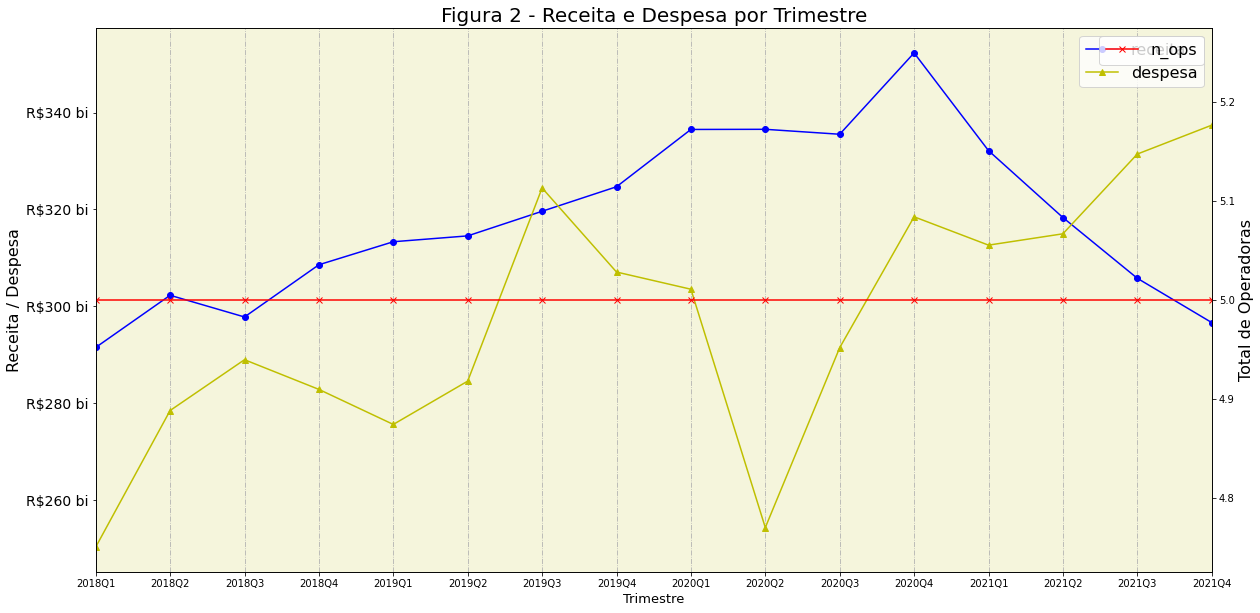

In [71]:
df_plot = ans_alterada25.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.savefig('ind_seg_01.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()
del df_plot

### Merge com a base de beneficiarios

In [72]:
###############################################################################################################################################################################################
#                                                                              SIB -   BENEFICIARIOS
###############################################################################################################################################################################################

#Caminho da pasta com as bases de dados beneficiarios
path_beneficiario = r'D:\TCC\tcc-main\Beneficiarios\Beneficiarios_operadora_e_carteira.csv'

sib = pd.read_csv(path_beneficiario, sep=';', encoding='utf-8')

sib.columns = ['cd_operadora', 'razao_social', 'gr_modalidade', 'vigencia_plano', 'gr_contratacao', 'tipo_financiamento', 'mes', 'id_cmpt', 'nr_benef']

sib['mes']= pd.to_datetime(sib['mes'], format='%Y%m', errors='coerce').dropna()

sib.columns = ['cd_ops', 'razao_social', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'id_cmpt', 'benef']

sib.loc[(sib.contratacao == 'Coletivo empresarial'),'contratacao'] = 'Empresarial'
sib.loc[(sib.contratacao == 'Coletivo por adesão'),'contratacao'] = 'Adesao'
sib.loc[(sib.contratacao == 'Individual ou familiar'),'contratacao'] = 'Individual'

sib = sib.loc[(sib['id_calendar'] >= Periodo[0]) & (sib['id_calendar'] <= Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'benef']]

sib['ano'] = sib['id_calendar'].dt.year

sib['trimestre'] = sib['id_calendar'].dt.to_period('Q')

sib = sib[['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

sib.sort_values(by=['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], inplace=True)

sib

,cd_ops,modalidade,vigencia,contratacao,financiamento,id_calendar,ano,trimestre,benef
146900,27,Médico-hospitalar,A,Individual,Não identificado,2017-09-01,2017,2017Q3,4
228965,27,Médico-hospitalar,A,Individual,Não identificado,2017-10-01,2017,2017Q4,4
332456,27,Médico-hospitalar,A,Individual,Não identificado,2017-11-01,2017,2017Q4,4
332180,27,Médico-hospitalar,A,Individual,Não identificado,2017-12-01,2017,2017Q4,4
33924,27,Médico-hospitalar,A,Individual,Não identificado,2018-01-01,2018,2018Q1,4
...,...,...,...,...,...,...,...,...,...
390516,422975,Odontológico,P,Adesao,Pre-estabelecido,2022-03-01,2022,2022Q1,137
137641,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-01-01,2022,2022Q1,92
250037,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-02-01,2022,2022Q1,99
29707,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-03-01,2022,2022Q1,115


In [73]:
# Segmenta porte da operadora pela quantidade de beneficiários médico-hospitalares

ops = sib.loc[(sib['id_calendar'] == Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

ops = ops.groupby(['cd_ops'], as_index=False)['benef'].agg('sum')

ops.loc[(ops.benef > 100000),'port_ops'] = 'Grande'
ops.loc[((ops.benef <= 100000) & (ops.benef >= 20000)  ),'port_ops'] = 'Médio'
ops.loc[(ops.benef < 20000),'port_ops'] = 'Pequeno'

ops.head()

,cd_ops,benef,port_ops
0,477,115244,Grande
1,515,33402,Médio
2,582,990798,Grande
3,701,614431,Grande
4,884,8336,Pequeno


In [74]:
filtro1 = sib['modalidade'].isin(['Médico-hospitalar'])
filtro2 = sib['financiamento'] != 'Não identificado'
filtro3 = sib['contratacao'].isin(['Empresarial', 'Individual', 'Adesao'])

sib_filtrada = sib.loc[filtro1 & filtro2 & filtro3]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','vigencia','contratacao', 'financiamento', 'id_calendar', 'trimestre'], as_index=False)['benef'].agg('sum')

sib_filtrada.replace('Pós-estabelecido','Pos-estabelecido', inplace=True)

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237
...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7
106447,2022,422835,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,14


In [75]:
#################################################################################################################################################################################
#Calcula média de beneficiários acumulada no ano por operadora e tipo de contratação:

sib_filtrada = sib_filtrada.sort_values(['ano','cd_ops','contratacao','id_calendar','trimestre','benef'], ascending=[True, True, True, True, True, False])

sib_filtrada['mes'] = sib_filtrada['id_calendar'].dt.month 

sib_filtrada['benefm'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].apply(lambda x: x.expanding().mean()))

sib_filtrada['n_meses'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].transform('size'))

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef', 'benefm', 'n_meses', 'mes']]

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef,benefm,n_meses,mes
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173,11173.000000,1,9
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909,10909.000000,3,10
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754,10831.500000,3,11
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584,10749.000000,3,12
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237,17237.000000,1,9
...,...,...,...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188,143.000000,2,3
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3,3.000000,4,1
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7,5.000000,4,2
106448,2022,422835,P,Empresarial,Pos-estabelecido,2022-03-01,2022Q1,646,218.666667,4,3


In [76]:
sib_filtrada = sib_filtrada.loc[sib_filtrada['mes'].isin([3,6,9,12])]

sib_filtrada.drop(['mes','benefm','n_meses'], axis='columns', inplace=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef']]

sib_filtrada['ano'] =  pd.to_datetime(sib_filtrada['ano'], format='%Y')

sib_filtrada['ano'] = sib_filtrada['ano'].dt.to_period('Y')

sib_filtrada['cd_ops'] = sib_filtrada['cd_ops'].astype('str')

sib_filtrada = sib_filtrada[(sib_filtrada['contratacao'] == tipo_contratacao)].reset_index(drop=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','trimestre','benef']]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','trimestre'],as_index=False).agg({'benef':'sum'})

sib_filtrada

,ano,cd_ops,trimestre,benef
0,2017,27,2017Q3,631
1,2017,27,2017Q4,614
2,2017,300012,2017Q3,770
3,2017,300012,2017Q4,757
4,2017,300136,2017Q3,4612
...,...,...,...,...
9861,2022,477,2022Q1,2004
9862,2022,5711,2022Q1,17310
9863,2022,6246,2022Q1,17089
9864,2022,701,2022Q1,1729


In [77]:
#Criação do dataframe final para ser utilizados na predição dos forecasts
ans_alterada25 = pd.merge(ans_alterada24,sib_filtrada, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25['modalidade'] = tipo_modalidade

ans_alterada25['contratacao'] = tipo_contratacao

ans_alterada25.to_csv('ind_seg.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25.head()

,ano,cd_ops,trimestre,receita,despesa,benef
0,2017,477,2017Q3,38005488.850000,42946986.860000,2674
1,2017,884,2017Q3,1191702.720000,1656150.780000,79
2,2017,884,2017Q4,422268.950000,492913.980000,78
3,2017,5711,2017Q3,346719290.000000,343740492.400000,25492
4,2017,477,2017Q4,13587719.890000,13328806.480000,2636


In [78]:
ans_alterada26 = ans_alterada25.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_million(x),
                                                                                    'despesa':lambda x: sum_million(x),
                                                                                    'benef': 'sum',
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada26['pct_despesa'] = ans_alterada26.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada26 = ans_alterada26[(ans_alterada26.trimestre > '2017Q4') & (ans_alterada26.trimestre < '2022Q1')]

ans_alterada26.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_alterada26 = ans_alterada26[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_alterada26.to_csv('ind_seg_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada26.set_index('trimestre', inplace=True)

display(ans_alterada26.info()) 
display(ans_alterada26) 

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2018Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   receita      16 non-null     float64
 1   despesa      16 non-null     float64
 2   benef        16 non-null     int64  
 3   n_ops        16 non-null     int64  
 4   pct_despesa  16 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 768.0 bytes


None

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,291.520000,250.310000,55593,5,85.860000
2018Q2,302.290000,278.500000,54200,5,92.130000
2018Q3,297.810000,288.990000,52992,5,97.040000
2018Q4,308.590000,282.860000,51520,5,91.660000
2019Q1,313.340000,275.630000,50264,5,87.970000
2019Q2,314.550000,284.570000,49032,5,90.470000
2019Q3,319.630000,324.440000,47820,5,101.500000
2019Q4,324.690000,307.090000,46607,5,94.580000
2020Q1,336.520000,303.540000,45612,5,90.200000


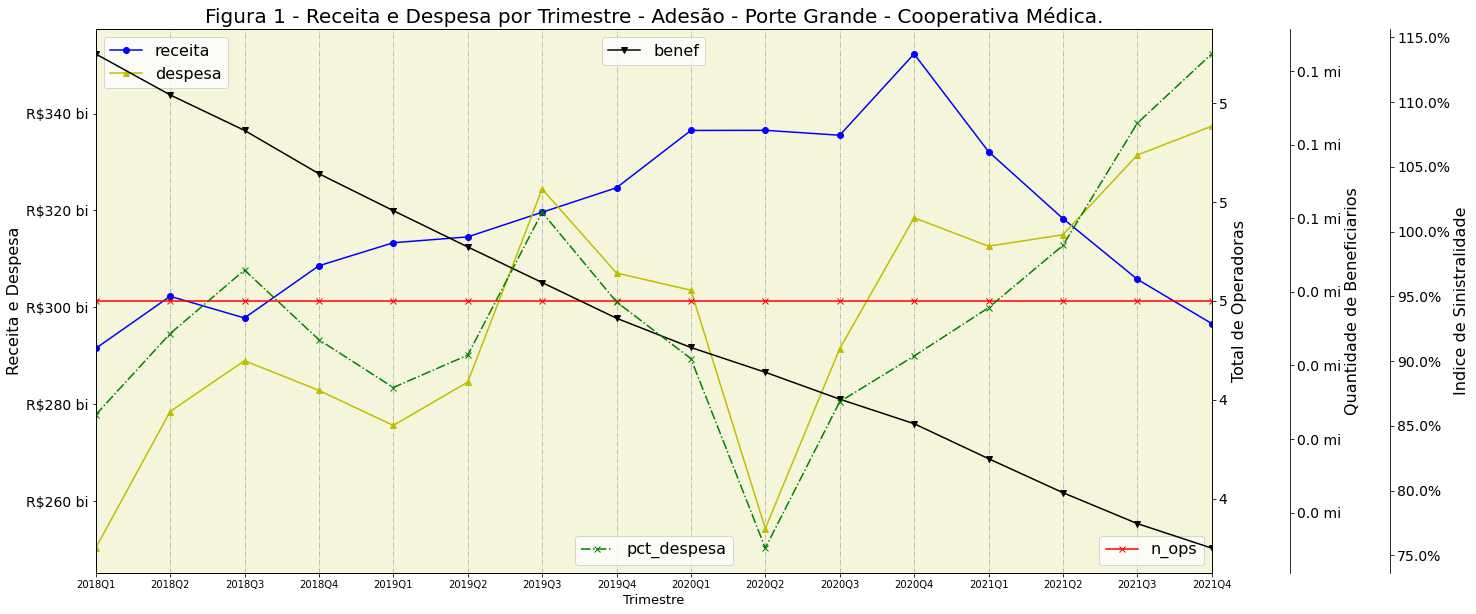

In [79]:
df_plot = ans_alterada26.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Adesão - Porte Grande - Cooperativa Médica.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'lower right', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1e6) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

ax4 = ax1.twinx()

ax4.spines.right.set_position(("axes", 1.16))

df_plot.plot(y=['pct_despesa'], figsize=(20,10), style=['gx-.'], ax=ax4)
ax4.set_xticks(df_plot.index)
ax4.set_xticklabels(df_plot.index)
ax4.set_xlabel('Trimestre', fontsize = 13)
yticks = ax4.get_yticks()
ax4.set_yticklabels(['{:.1f}%'.format(x) for x in yticks], fontsize = 14)
ax4.set_ylabel('Indice de Sinistralidade', fontsize=16)
ax4.legend(loc = 'lower center', fontsize = 16)

plt.savefig('ind_seg_02.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot